 ## Data Prep

 We'll load Shiller's file that he publishes on his website: https://shillerdata.com/

 This contains a historical time series of stock and bond market performance going back to 1871.


In [1]:
import os
import time
import requests
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from pathlib import Path
from datetime import datetime, timedelta
from scipy.interpolate import RegularGridInterpolator
from multiprocessing import Pool, cpu_count
from itertools import product
from tqdm import tqdm

In [2]:
def parse_shiller_date(series):
    """
    Convert Shiller-style yyyy.mm strings/floats into proper datetimes.
    Examples:
      1950.01 -> 1950-01-01
      1950.1  -> 1950-10-01
      1950.11 -> 1950-11-01
    """
    s = series.astype(str).str.strip()

    def _norm(val):
        year, month_part = val.split(".", 1)
        # Special case: .1 means October (Excel dropped the zero)
        if month_part == "1":
            month = "10"
        else:
            month = month_part.zfill(2)
        return f"{year}-{month}-01"

    return pd.to_datetime(s.map(_norm), format="%Y-%m-%d")

In [29]:
local_path = Path(os.path.join("tempdir", "shillerdata.xls"))

# This is the link found in https://shillerdata.com/
url = "https://img1.wsimg.com/blobby/go/e5e77e0b-59d1-44d9-ab25-4763ac982e53/downloads/9becfac9-1778-47a6-b40e-299d8c616706/ie_data.xls"

# Check if file exists and is less than 30 days old
def needs_update(path, days=30):
    if not path.exists():
        return True
    age_days = (time.time() - path.stat().st_mtime) / (24 * 3600)
    return age_days > days

# Download if missing or outdated
if needs_update(local_path):
    local_path.parent.mkdir(parents=True, exist_ok=True)
    r = requests.get(url)
    r.raise_for_status()
    with open(local_path, "wb") as f:
        f.write(r.content)

# Read multi-line headers (rows 4–7) and collapse them
headers_raw = pd.read_excel(local_path, sheet_name="Data", skiprows=4, nrows=4, header=None)
headers = (
    headers_raw.fillna("")
    .astype(str)
    .agg(" ".join)           # join rows into one string
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)  # clean spaces
)

# Read the actual data (starting row 8)
df = pd.read_excel(local_path, sheet_name="Data", skiprows=8)
df.columns = headers

# Drop the last row which contains footnotes
df = df.iloc[:-1].reset_index(drop=True)

# TEMPORARY: Also drop the second to last row which as of 20250913 is a duplicate
df = df.iloc[:-1].reset_index(drop=True)

df["Date"] = parse_shiller_date(df["Date"])

df.tail()

,Date,S&P Comp. P,Dividend D,Earnings E,Consumer Price Index CPI,Date Fraction,Long Interest Rate GS10,Real Price,Real Dividend,Real Total Return Price,...,Earnings Ratio P/E10 or CAPE,,Earnings Ratio TR P/E10 or TR CAPE,,Excess CAPE Yield,Monthly Total Bond Returns,Real Total Bond Returns,10 Year Annualized Stock Real Return,10 Year Annualized Bonds Real Return,Real 10 Year Excess Annualized Returns
1850,2025-04-01,5369.495714,76.546867,219.026667,320.795,2025.291667,4.28,5413.320220,77.171624,3.641872e+06,...,32.621270,NaN,35.015341,NaN,0.018767,0.992343,39.643654,NaN,NaN,NaN
1851,2025-05-01,5810.919524,76.948434,221.363333,321.465,2025.375000,4.42,5846.136807,77.414782,3.937395e+06,...,35.076007,NaN,37.636543,NaN,0.014912,1.006896,39.258095,NaN,NaN,NaN
1852,2025-06-01,6029.9515,77.350000,223.700000,322.561,2025.458333,4.38,6045.883451,77.554369,4.076277e+06,...,36.108975,NaN,38.730193,NaN,0.014487,1.002847,39.394513,NaN,NaN,NaN
1853,2025-07-01,6296.498182,NaN,NaN,323.048,2025.541667,4.39,6303.617235,NaN,4.250048e+06,...,37.469882,NaN,40.132464,NaN,0.013530,1.014158,39.447119,NaN,NaN,NaN
1854,2025-08-01,6408.949524,NaN,NaN,323.2915,2025.625000,4.26,6411.363103,NaN,4.322692e+06,...,38.031442,NaN,40.708786,NaN,0.014659,1.005976,39.975485,NaN,NaN,NaN


## Simulation Method

We'll first define a function to compute the time series of portfolio values over a date range, aka a single "simulation path". Each date in the range represents the start of a 1-month period. For each of those start dates, we'll supply a withdrawal amount, then simulate withdrawing that much from the portfolio during the corresponding period.

Note that the path is run using constant (real) dollars and with reinvestment of dividends/interest assumed. We use the "real total return" columns in the spreadsheet which are built based on these assumptions.

In [31]:
def run_retirement_simulation(df, withdrawals, initial_value=1_000_000, stock_pct=0.75):
    """
    df: DataFrame with 'Date' and 'Real Total Return Price'
    withdrawals: DataFrame with ['Date', 'Withdrawal'] for the desired analysis period
    initial_value: Portfolio value at start of period
    stock_pct: Percentage allocated to stocks

    TODO: Add optional "trippable backstops" e.g. selling a house when portfolio value goes below a threshold.
    Take care to implement efficiently since cube building runs this function in a tight inner loop.
    """
    df = df.copy()

    # Verify withdrawals has required columns
    if 'Date' not in withdrawals.columns or 'Withdrawal' not in withdrawals.columns:
        raise ValueError(f"Withdrawals DataFrame must have 'Date' and 'Withdrawal' columns. Found: {list(withdrawals.columns)}")

    # Merge and check for alignment
    merged_df = df.merge(withdrawals, on="Date", how="inner")

    # Check for duplicates
    if merged_df.duplicated(subset="Date").any():
        raise ValueError(f"Withdrawals DataFrame contains duplicate dates: {merged_df[merged_df.duplicated(subset='Date')]['Date'].tolist()}")

    # Check if merge resulted in expected number of rows
    if len(merged_df) != len(withdrawals):
        print(f"Warning: Merge resulted in {len(merged_df)} rows, expected {len(withdrawals)}")
        missing_dates = set(withdrawals['Date']) - set(merged_df['Date'])
        raise ValueError(f"Withdrawals contain {len(missing_dates)} dates not found in market data: {sorted(list(missing_dates))[:5]}{'...' if len(missing_dates) > 5 else ''}")

    # Check for any NaN values in Withdrawal column after merge
    if merged_df['Withdrawal'].isna().any():
        nan_dates = merged_df[merged_df['Withdrawal'].isna()]['Date'].tolist()
        raise ValueError(f"Withdrawal values are NaN for dates: {nan_dates[:5]}{'...' if len(nan_dates) > 5 else ''}")

    df = merged_df

    # Baseline for computing real returns
    stock_base = df["Real Total Return Price"].iloc[0]
    bond_base = df["Real Total Bond Returns"].iloc[0]

    # Compute growth factors as numpy arrays for speed
    stock_growth = (df["Real Total Return Price"].values / stock_base)
    bond_growth = (df["Real Total Bond Returns"].values / bond_base)
    combined_growth = stock_growth * stock_pct + bond_growth * (1 - stock_pct)

    # Compute period-over-period growth rates
    growth_rates = np.ones(len(combined_growth))
    growth_rates[1:] = combined_growth[1:] / combined_growth[:-1]

    # Vectorized portfolio value calculation
    withdrawals_array = df["Withdrawal"].values

    # Initialize portfolio values array
    portfolio_values = np.zeros(len(df))
    portfolio_values[0] = initial_value - withdrawals_array[0]

    # Vectorized cumulative calculation
    for i in range(1, len(portfolio_values)):
        portfolio_values[i] = (portfolio_values[i-1] * growth_rates[i]) - withdrawals_array[i]
        # Early termination if we go bankrupt
        if portfolio_values[i] <= 0:
            portfolio_values[i:] = 0
            break

    df["Period End Value"] = portfolio_values
    return df[["Date", "Period End Value", "Withdrawal"]]

## Constant Withdrawals

The simplest scenario is a constant withdrawal, unchanging for the duration of the retirement time window.

This is the methodology behind the famous (infamous?) 4% rule invented by Bill Bengen: withdraw 4% of the portfolio's initial value per year, adjusted for inflation, no matter what happens. It works (aka yields a series of strictly positive portfolio values) most of the time.

For fun, let's simulate one of the hypothetical early retirement paths where it doesn't work: the 50 years between 1962 and 2012.

In [5]:
def get_constant_withdrawals(data, start_date, end_date, initial_value=1_000_000, annual_percent_level=0.04):
    """
    Create a dataframe of constant withdrawals over a date range.

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing a "Date" column (yyyy.mm format).
    start_date : pd.DateTime
        Starting date of the withdrawal range.
    end_date : pd.DateTime
        Ending date of the withdrawal range.
    initial_value : float, optional
        Initial portfolio value (default 1,000,000).
    annual_percent_level : float, optional
        Annual withdrawal rate (default 0.04 = 4%).

    Returns
    -------
    pd.DataFrame
        A dataframe with Date and Withdrawal columns.

    TODO: Add optional "from this date forward" constant cashflows, e.g. social security, pensions.
    """
    data = data.copy()

    # filter range
    mask = (data["Date"] >= start_date) & (data["Date"] <= end_date)
    subset = data.loc[mask, ["Date"]].reset_index(drop=True)

    # compute withdrawal value
    withdrawal_value = initial_value * annual_percent_level / 12
    subset["Withdrawal"] = withdrawal_value

    return subset

In [32]:
four_pct_withdrawals = get_constant_withdrawals(df, start_date="1962-01-01", end_date="2011-12-01")
four_pct_simulation = run_retirement_simulation(df, four_pct_withdrawals)
four_pct_simulation.head()

,Date,Period End Value,Withdrawal
0,1962-01-01,9.966667e+05,3333.333333
1,1962-02-01,1.005909e+06,3333.333333
2,1962-03-01,1.008249e+06,3333.333333
3,1962-04-01,9.820470e+05,3333.333333
4,1962-05-01,9.264798e+05,3333.333333


### Plot the portfolio value and withdrawal over the period.

In [9]:
def plot_portfolio(df):
    """
    Create two stacked plots:
    1. Portfolio value over time (Y axis in $M, adaptive tick/grid spacing, min at 0 or below if needed)
    2. Withdrawals over time (Y axis in $K, with 1K horizontal guidelines, as bars)
    """
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(12, 8), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # --- Plot 1: Portfolio values ---
    ax1.plot(df["Date"], df["Period End Value"], label="Portfolio Value", linewidth=2)

    # Adaptive y-axis ticks
    y_min, y_max = df["Period End Value"].min(), df["Period End Value"].max()
    y_range = y_max - y_min
    candidates = [100_000, 500_000, 1_000_000, 5_000_000]
    step = min(candidates, key=lambda c: abs((y_range / c) - 10))

    # Round limits to multiples of step
    y_min_rounded = np.floor(y_min / step) * step
    y_max_rounded = np.ceil(y_max / step) * step
    y_min_final = min(0, y_min_rounded)
    ax1.set_ylim(y_min_final, y_max_rounded)

    ax1.yaxis.set_major_locator(mtick.MultipleLocator(step))
    ax1.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f"${x/1_000_000:.1f}M")
    )
    ax1.grid(axis="y", which="major", color="lightgray", linestyle="--", linewidth=0.7)
    ax1.axhline(0, color="lightgray", linewidth=1)
    ax1.set_ylabel("Portfolio Value")
    ax1.set_title("Portfolio with Withdrawals")
    ax1.legend()

    # --- Plot 2: Withdrawals (bars) ---
    ax2.bar(df["Date"], df["Withdrawal"],
            color="tab:red", alpha=0.7, label="Withdrawal", width=20)

    w_min, w_max = df["Withdrawal"].min(), df["Withdrawal"].max()
    w_step = 1000  # fixed 1K spacing
    w_min_final = min(0, np.floor(w_min / w_step) * w_step)
    w_max_final = np.ceil(w_max / w_step) * w_step
    ax2.set_ylim(w_min_final, w_max_final)

    ax2.yaxis.set_major_locator(mtick.MultipleLocator(w_step))
    ax2.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f"${x/1_000:.0f}K")
    )
    ax2.grid(axis="y", which="major", color="lightgray", linestyle="--", linewidth=0.7)
    ax2.set_ylabel("Withdrawals")
    ax2.legend()

    # Shared x-axis
    ax2.set_xlabel("Date")
    ax2.xaxis.set_major_locator(mdates.YearLocator(5))   # every 5 years
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    plt.tight_layout()
    plt.show()

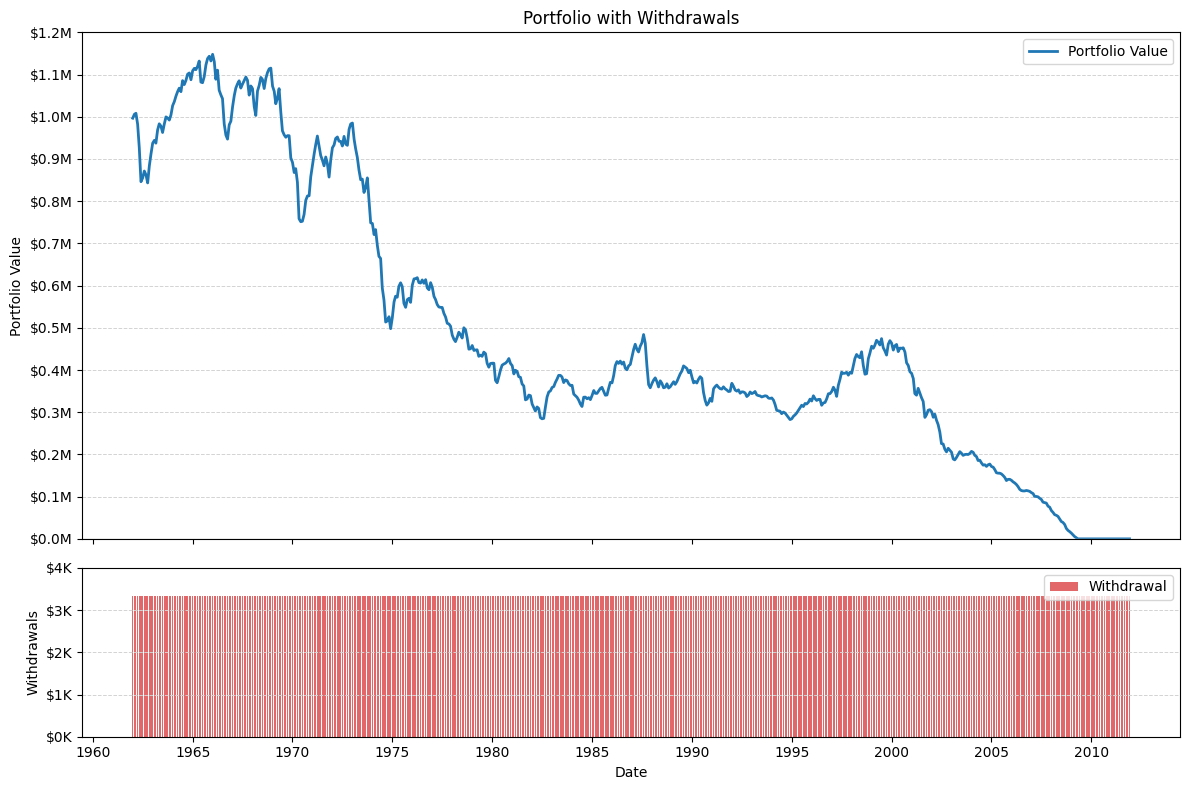

In [10]:
plot_portfolio(four_pct_simulation)

### Now run multiple simulation paths at the 4% rule to see the distribution.

In [44]:
def run_constant_withdrawals(df, annual_withdrawal_rate, num_months, stock_pct=0.75,
                             analysis_start_date='1871-01-01', initial_value=1_000_000,
                             verbose=False, return_full_paths=False):
    """
    Calculate all simulation paths for given parameters and return path details.

    Parameters
    ----------
    df : pd.DataFrame
        Market data
    annual_withdrawal_rate : float
        Annual withdrawal rate
    num_months : int
        Number of months in each simulation
    stock_pct : float
        Stock allocation percentage
    analysis_start_date : str
        Start date for analysis
    initial_value : float
        Initial portfolio value
    verbose : bool
        Print progress
    return_full_paths : bool
        If True, also return a DataFrame with all simulation details

    Returns
    -------
    list of tuples or tuple
        If return_full_paths=False: list of (start_date, end_date, final_value) tuples
        If return_full_paths=True: (path_results, full_paths_df) where full_paths_df
            contains all intermediate values with a run_idx column
    """
    # Convert analysis_start_date to datetime
    analysis_start = pd.to_datetime(analysis_start_date)

    # Filter dataframe to only include dates from analysis_start_date onwards
    df_filtered = df[df['Date'] >= analysis_start].copy()

    # Get all possible starting dates for simulation periods
    max_end_idx = len(df_filtered) - num_months
    if max_end_idx <= 0:
        if return_full_paths:
            return [], pd.DataFrame()
        return []  # Not enough data

    num_paths = max_end_idx + 1

    start_time = datetime.now()
    if verbose:
        print(f"{start_time.strftime('%H:%M:%S')} Starting simulation for WR = {annual_withdrawal_rate:.4f}, "
              f"num_months = {num_months}, starting = {analysis_start_date}, stock_pct = {stock_pct:.2f}, "
              f"num_paths = {num_paths}...")

    path_results = []
    full_paths_list = [] if return_full_paths else None

    for run_idx in range(num_paths):
        # Define the period for this simulation
        start_date = df_filtered.iloc[run_idx]['Date']
        end_idx = run_idx + num_months - 1
        end_date = df_filtered.iloc[end_idx]['Date']

        # Get withdrawals for this period
        withdrawals = get_constant_withdrawals(
            df_filtered,
            start_date,
            end_date,
            initial_value=initial_value,
            annual_percent_level=annual_withdrawal_rate
        )

        # Run vectorized simulation for this period
        simulation_result = run_retirement_simulation(
            df_filtered.iloc[run_idx:end_idx+1],
            withdrawals,
            initial_value=initial_value,
            stock_pct=stock_pct
        )

        # Get the final value (could be 0 if bankrupt)
        final_value = simulation_result['Period End Value'].iloc[-1]

        # Store the path result
        # We store final_value as-is (0 if failed, positive if succeeded)
        path_results.append((start_date, end_date, final_value))

        # Store full path if requested
        if return_full_paths:
            sim_df = simulation_result.copy()
            sim_df['run_idx'] = run_idx
            sim_df['start_date'] = start_date
            sim_df['end_date'] = end_date
            full_paths_list.append(sim_df)

    if verbose:
        total_seconds = (datetime.now() - start_time).total_seconds()
        print(f"...Done simulating {num_paths} retirement paths, took {total_seconds:.1f} seconds")

    if return_full_paths:
        # Combine all simulation results into one DataFrame
        full_paths_df = pd.concat(full_paths_list, ignore_index=True)
        return path_results, full_paths_df

    return path_results

In [45]:
    _, four_percent_paths = run_constant_withdrawals(df,
                                                     annual_withdrawal_rate=0.04,
                                                     num_months=360,
                                                     stock_pct=0.75,
                                                     analysis_start_date='1925-01-01',
                                                     initial_value=1_000_000,
                                                     verbose=True,
                                                     return_full_paths=True)

    four_percent_paths.head()

23:30:16 Starting simulation for WR = 0.0400, num_months = 360, starting = 1925-01-01, stock_pct = 0.75, num_paths = 849...
...Done simulating 849 retirement paths, took 7.1 seconds


,Date,Period End Value,Withdrawal,run_idx,start_date,end_date
0,1925-01-01,9.966667e+05,3333.333333,0,1925-01-01,1954-12-01
1,1925-02-01,1.009945e+06,3333.333333,0,1925-01-01,1954-12-01
2,1925-03-01,9.853937e+05,3333.333333,0,1925-01-01,1954-12-01
3,1925-04-01,9.844310e+05,3333.333333,0,1925-01-01,1954-12-01
4,1925-05-01,1.003278e+06,3333.333333,0,1925-01-01,1954-12-01


In [56]:
def plot_portfolio_paths(df, alpha=0.1, highlight_runs=None, figsize=(12, 8)):
    """
    Plot multiple portfolio simulation paths.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with columns: Date, Period End Value, Withdrawal, run_idx
        Contains multiple simulation runs identified by run_idx
    alpha : float
        Transparency for individual paths (lower = more transparent)
    highlight_runs : list or None
        List of run_idx values to highlight in bold
    figsize : tuple
        Figure size (width, height)
    """
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=figsize, sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # Get unique runs
    runs = df['run_idx'].unique()
    num_runs = len(runs)

    # Color setup - use a colormap for variety if many paths
    if num_runs <= 10:
        colors = plt.cm.tab10(np.linspace(0, 1, num_runs))
    else:
        # For many paths, use color gradient based on percentile of final value
        final_values = df.groupby('run_idx')['Period End Value'].last().values

        # Convert to percentiles to avoid outlier issues
        from scipy import stats
        percentiles = stats.rankdata(final_values, method='average') / len(final_values)

        # Use RdBu (not reversed) - low percentile paths are red, high percentile are blue
        colors = plt.cm.RdBu(percentiles)

    # Determine the number of months for x-axis
    months_per_run = df.groupby('run_idx').size().iloc[0]
    x_months = np.arange(months_per_run)

    # --- Plot 1: Portfolio values ---
    for i, run_idx in enumerate(runs):
        run_data = df[df['run_idx'] == run_idx].copy()

        # Reset index to use month numbers instead of dates
        run_data = run_data.reset_index(drop=True)

        # Determine line properties
        if highlight_runs and run_idx in highlight_runs:
            linewidth = 2
            line_alpha = 1.0
            zorder = 10
        else:
            linewidth = 0.5
            line_alpha = alpha
            zorder = 1

        # Plot portfolio value path using month index
        ax1.plot(x_months, run_data["Period End Value"],
                linewidth=linewidth, alpha=line_alpha,
                color=colors[i] if num_runs <= 10 else colors[i],
                zorder=zorder)

    # Adaptive y-axis ticks for portfolio values
    y_min, y_max = df["Period End Value"].min(), df["Period End Value"].max()
    y_range = y_max - y_min
    candidates = [100_000, 500_000, 1_000_000, 5_000_000]
    step = min(candidates, key=lambda c: abs((y_range / c) - 10))

    y_min_rounded = np.floor(y_min / step) * step
    y_max_rounded = np.ceil(y_max / step) * step
    y_min_final = min(0, y_min_rounded)
    ax1.set_ylim(y_min_final, y_max_rounded)

    ax1.yaxis.set_major_locator(mtick.MultipleLocator(step))
    ax1.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f"${x/1_000_000:.1f}M")
    )
    ax1.grid(axis="y", which="major", color="lightgray", linestyle="--", linewidth=0.7)
    ax1.axhline(0, color="black", linewidth=1, alpha=0.3)
    ax1.set_ylabel("Portfolio Value")
    ax1.set_title(f"Portfolio Simulation Paths (n={num_runs})")

    # Add success rate annotation
    success_rate = (df.groupby('run_idx')['Period End Value'].last() > 0).mean()
    ax1.text(0.02, 0.98, f'Success Rate: {success_rate:.1%}',
            transform=ax1.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # --- Plot 2: Withdrawals (lines instead of bars) ---
    for i, run_idx in enumerate(runs):
        run_data = df[df['run_idx'] == run_idx].copy()

        # Reset index to use month numbers
        run_data = run_data.reset_index(drop=True)

        # Determine line properties
        if highlight_runs and run_idx in highlight_runs:
            linewidth = 2
            line_alpha = 1.0
            zorder = 10
        else:
            linewidth = 0.5
            line_alpha = alpha
            zorder = 1

        # Plot withdrawal path as line using month index
        ax2.plot(x_months, run_data["Withdrawal"],
                linewidth=linewidth, alpha=line_alpha,
                color='tab:red', zorder=zorder)

    # Y-axis for withdrawals
    w_min, w_max = df["Withdrawal"].min(), df["Withdrawal"].max()
    w_step = 1000  # fixed 1K spacing
    w_min_final = min(0, np.floor(w_min / w_step) * w_step)
    w_max_final = np.ceil(w_max / w_step) * w_step
    ax2.set_ylim(w_min_final, w_max_final)

    ax2.yaxis.set_major_locator(mtick.MultipleLocator(w_step))
    ax2.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f"${x/1_000:.0f}K")
    )
    ax2.grid(axis="y", which="major", color="lightgray", linestyle="--", linewidth=0.7)
    ax2.set_ylabel("Withdrawals")

    # X-axis shows months
    ax2.set_xlabel("Months into Retirement")
    ax2.set_xlim(0, months_per_run - 1)

    # Set x-axis ticks to show years
    year_ticks = np.arange(0, months_per_run, 60)  # Every 5 years
    ax2.set_xticks(year_ticks)
    ax2.set_xticklabels([f"Year {int(m/12)}" for m in year_ticks])

    plt.tight_layout()
    plt.show()

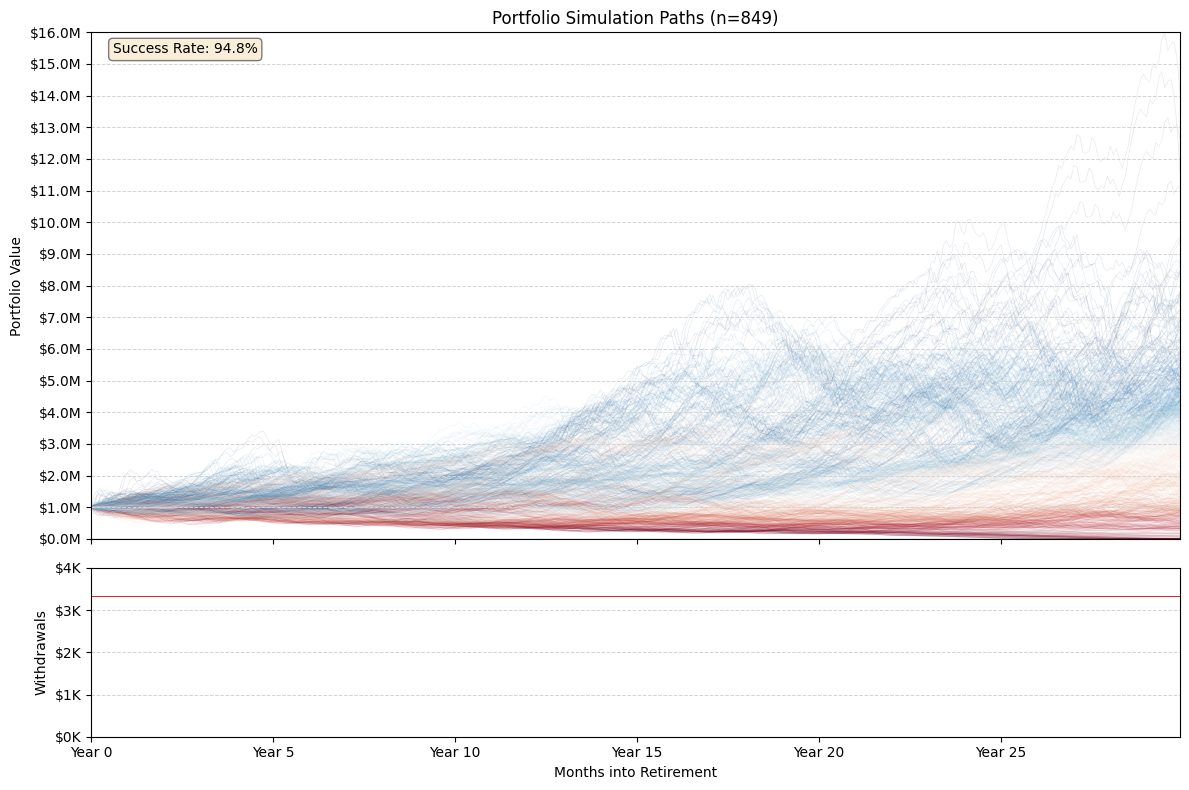

In [57]:
plot_portfolio_paths(four_percent_paths)

# Goal Seek - Working Backwards

Great, we've now mastered FIRE 101. We pick a withdrawal rate (4%) and get a success rate (94.8% for all 30 year retirement paths since 1925).

Now it's time to start putting together the building blocks of the guardrails strategy. To do that, the fundamental thing we need to do is to work backwards from the above - given a desired success rate, to work out the withdrawal rate that results in it.

The simplest way to do that is to do a goal-seek or guess-and-check operation, trying different withdrawal rates until we find one that results in the desired success rate (or within some threshold of it).

Let's see how that plays out:

In [60]:
def get_wr_for_fixed_success_rate(df, desired_success_rate, num_months,
                                   analysis_start_date='1871-01-01',
                                   initial_value=1_000_000, stock_pct=0.75,
                                   tolerance=0.001, max_iterations=50):
    """
    Compute the annual withdrawal rate such that a historical simulation over periods of the desired length
    yields the desired success rate.

    Parameters
    ----------
    df : pd.DataFrame
        The main dataframe with market data
    desired_success_rate : float
        The target chance of underspending (e.g., 0.90 for 90%),
        the percent of simulation paths that should have ending portfolio values > 0.
    num_months : int
        The size of the time window of the historical simulation paths to run
        (corresponds to the remaining time in retirement).
    analysis_start_date : str, optional
        The start date from which we should begin running simulation paths,
        if we do not want to start at the very beginning.
    initial_value : float, optional
        Initial portfolio value (default 1,000,000)
    stock_pct : float, optional
        Percentage of portfolio in stocks (default 0.75)
    tolerance : float, optional
        Tolerance for success rate matching (default 0.001 = 0.1%)
    max_iterations : int, optional
        Maximum iterations for binary search (default 50)

    Returns
    -------
    dict
        Dictionary containing:
        - 'withdrawal_rate': The annual withdrawal rate that achieves the target success rate
        - 'actual_success_rate': The actual success rate achieved
        - 'num_simulations': Number of simulation paths run
        - 'iterations': Number of binary search iterations performed
    """

    # Convert analysis_start_date to datetime
    analysis_start = pd.to_datetime(analysis_start_date)

    # Filter dataframe to only include dates from analysis_start_date onwards
    df_filtered = df[df['Date'] >= analysis_start].copy()

    # Get all possible starting dates for simulation periods
    max_end_idx = len(df_filtered) - num_months
    if max_end_idx <= 0:
        raise ValueError(f"Not enough data for {num_months} month simulations starting from {analysis_start_date}")

    num_paths = max_end_idx + 1

    # Binary search for the withdrawal rate
    low_rate = 0.001  # 0.1% annual withdrawal rate
    high_rate = 0.20   # 20% annual withdrawal rate

    iteration = 0
    best_rate = None
    best_success_rate = None

    print(f"\nSearching for withdrawal rate with {desired_success_rate:.1%} success rate...\n")

    while iteration < max_iterations:
        mid_rate = (low_rate + high_rate) / 2

        retirement_paths = run_constant_withdrawals(df, mid_rate, num_months, stock_pct,
                                                    analysis_start_date, initial_value, verbose=True)

        current_success_rate = sum(1 for _, _, val in retirement_paths if val > 0) / num_paths

        # Check if we're within tolerance
        if abs(current_success_rate - desired_success_rate) <= tolerance:
            best_rate = mid_rate
            best_success_rate = current_success_rate
            print(f"\nConverged! Found withdrawal rate within tolerance.\n")
            break

        # Adjust search bounds
        # If success rate is too high, we can withdraw more
        if current_success_rate > desired_success_rate:
            low_rate = mid_rate
            print(f"Success rate too high ({current_success_rate:.3f} > {desired_success_rate:.3f}), "
                  f"increasing withdrawal rate range to [{low_rate:.4f}, {high_rate:.4f}]\n")
        else:
            # If success rate is too low, we need to withdraw less
            high_rate = mid_rate
            print(f"Success rate too low ({current_success_rate:.3f} < {desired_success_rate:.3f}), "
                  f"decreasing withdrawal rate range to [{low_rate:.4f}, {high_rate:.4f}]\n")

        best_rate = mid_rate
        best_success_rate = current_success_rate
        iteration += 1

    if iteration >= max_iterations:
        print(f"\nReached maximum iterations ({max_iterations}). Returning best found rate.\n")

    # Return results
    return {
        'withdrawal_rate': best_rate,
        'actual_success_rate': best_success_rate,
        'num_simulations': num_paths,
        'iterations': iteration + 1
    }

In [61]:
# Example: Find withdrawal rate for 90% success rate over 30-year periods
result = get_wr_for_fixed_success_rate(
    df=df,
    desired_success_rate=0.90,
    num_months=360,  # 30 years
    analysis_start_date='1871-01-01',
    initial_value=1_000_000,
    stock_pct=0.75
)

print(f"Annual withdrawal rate for 90% success rate: {result['withdrawal_rate']:.4f} ({result['withdrawal_rate']*100:.2f}%)")
print(f"Actual success rate achieved: {result['actual_success_rate']:.4f} ({result['actual_success_rate']*100:.2f}%)")
print(f"Number of simulation paths: {result['num_simulations']}")
print(f"Binary search iterations: {result['iterations']}")


Searching for withdrawal rate with 90.0% success rate...

23:44:30 Starting simulation for WR = 0.1005, num_months = 360, starting = 1871-01-01, stock_pct = 0.75, num_paths = 1496...
...Done simulating 1496 retirement paths, took 11.6 seconds
Success rate too low (0.087 < 0.900), decreasing withdrawal rate range to [0.0010, 0.1005]

23:44:42 Starting simulation for WR = 0.0508, num_months = 360, starting = 1871-01-01, stock_pct = 0.75, num_paths = 1496...
...Done simulating 1496 retirement paths, took 11.1 seconds
Success rate too low (0.793 < 0.900), decreasing withdrawal rate range to [0.0010, 0.0508]

23:44:53 Starting simulation for WR = 0.0259, num_months = 360, starting = 1871-01-01, stock_pct = 0.75, num_paths = 1496...
...Done simulating 1496 retirement paths, took 11.3 seconds
Success rate too high (1.000 > 0.900), increasing withdrawal rate range to [0.0259, 0.0508]

23:45:04 Starting simulation for WR = 0.0383, num_months = 360, starting = 1871-01-01, stock_pct = 0.75, num_

We got an answer! A 4.55% withdrawal rate gives us a 90.04% chance of success. But it took about 2 minutes to run the whole thing.

The guardrails strategy requires us to do this operation - finding the "target spending", or the desired withdrawal rate for the target chance of success - every month (because the number of months to retirement decreases by 1, we have to do the calculation again). Therefore, to run even one path would take 2 minutes * 360 months = 720 minutes or 12 hours. And of course to fully test it on all historical 30-year time series since 1871 - 1496 of them - would take about two years (on one core)!

Obviously that ain't gonna work. But if you think about it, a lot of the work we're doing is somewhat repetitive. We are going to end up running the same time period for the same chance of success quite a few times during that 2 year simulation run.

Instead of that, let's pick some reasonable level of granularity and do all the runs upfront.

# Behold... The Cube!

We can build up a "cube" of runs with three axes: time period durations, withdrawal rates, and % stock allocations. For each run we'll get a success rate. We can save that as a file, since we'd only have to rebuild it when new Shiller data comes out. Until then, that fundamental and oft-repeated operation - finding the withdrawal rate that gives us a desired chance of success - becomes a quick lookup, with interpolation (that assumes some level of monotonicity, of course, which we can validate!)


In [ ]:


class RetirementSuccessCube:
    """
    A class to store and query pre-computed retirement simulation paths.

    Instead of storing just success rates, this stores the actual simulation
    path results (start_date, end_date, final_value) for each grid point,
    allowing for flexible date filtering.
    """

    def __init__(self, cube_data=None, time_axis=None, wr_axis=None, stock_axis=None):
        """
        Initialize the cube with data and axes.

        Parameters
        ----------
        cube_data : np.ndarray or None
            3D array where each element is a list of (start_date, end_date, final_value) tuples
        time_axis : np.ndarray or None
            Array of time periods in months
        wr_axis : np.ndarray or None
            Array of withdrawal rates (as decimals, e.g., 0.04 for 4%)
        stock_axis : np.ndarray or None
            Array of stock allocations (as decimals, e.g., 0.75 for 75%)
        """
        self.cube_data = cube_data
        self.time_axis = time_axis
        self.wr_axis = wr_axis
        self.stock_axis = stock_axis

    def _get_nearest_indices(self, num_months, withdrawal_rate, stock_pct):
        """Find the nearest grid indices for given parameters."""
        time_idx = np.argmin(np.abs(self.time_axis - num_months))
        wr_idx = np.argmin(np.abs(self.wr_axis - withdrawal_rate))
        stock_idx = np.argmin(np.abs(self.stock_axis - stock_pct))
        return time_idx, wr_idx, stock_idx

    def _calculate_success_rate(self, path_results, date_start=None, date_end=None):
        """
        Calculate success rate from path results with optional date filtering.

        Parameters
        ----------
        path_results : list of tuples
            List of (start_date, end_date, final_value) tuples
        date_start : pd.Timestamp or None
            Only include paths that start on or after this date
        date_end : pd.Timestamp or None
            Only include paths that start on or before this date

        Returns
        -------
        float
            Success rate (fraction of paths with positive final value)
        """
        if not path_results:
            return 0.0

        # Filter paths by date range if specified
        filtered_paths = path_results

        if date_start is not None:
            date_start = pd.to_datetime(date_start)
            filtered_paths = [p for p in filtered_paths if p[0] >= date_start]

        if date_end is not None:
            date_end = pd.to_datetime(date_end)
            filtered_paths = [p for p in filtered_paths if p[0] <= date_end]

        if not filtered_paths:
            return 0.0

        # Calculate success rate
        successes = sum(1 for _, _, final_val in filtered_paths if final_val > 0)
        return successes / len(filtered_paths)

    def get_success_rate(self, num_months, withdrawal_rate, stock_pct,
                        date_start=None, date_end=None, interpolate=True):
        """
        Get success rate for given parameters with optional date filtering.

        Parameters
        ----------
        num_months : int
            Time period in months
        withdrawal_rate : float
            Annual withdrawal rate (e.g., 0.04 for 4%)
        stock_pct : float
            Stock allocation (e.g., 0.75 for 75%)
        date_start : str or pd.Timestamp or None
            Only include paths starting on or after this date
        date_end : str or pd.Timestamp or None
            Only include paths starting on or before this date
        interpolate : bool
            If True, interpolate between grid points; if False, use nearest

        Returns
        -------
        float
            Success rate
        """
        if self.cube_data is None:
            raise ValueError("Cube not initialized with data")

        if interpolate and date_start is None and date_end is None:
            # Use interpolation when no date filtering is needed
            return self._get_interpolated_success_rate(num_months, withdrawal_rate, stock_pct)
        else:
            # Use nearest neighbor when date filtering is needed
            time_idx, wr_idx, stock_idx = self._get_nearest_indices(
                num_months, withdrawal_rate, stock_pct
            )
            path_results = self.cube_data[time_idx, wr_idx, stock_idx]
            return self._calculate_success_rate(path_results, date_start, date_end)

    def _get_interpolated_success_rate(self, num_months, withdrawal_rate, stock_pct):
        """
        Get interpolated success rate (without date filtering).

        This creates a temporary success rate grid and interpolates.
        """
        # Create success rate grid for interpolation
        if not hasattr(self, '_success_rate_grid'):
            shape = (len(self.time_axis), len(self.wr_axis), len(self.stock_axis))
            self._success_rate_grid = np.zeros(shape)

            for i in range(len(self.time_axis)):
                for j in range(len(self.wr_axis)):
                    for k in range(len(self.stock_axis)):
                        path_results = self.cube_data[i, j, k]
                        self._success_rate_grid[i, j, k] = self._calculate_success_rate(path_results)

            self._interpolator = RegularGridInterpolator(
                (self.time_axis, self.wr_axis, self.stock_axis),
                self._success_rate_grid,
                method='linear',
                bounds_error=False,
                fill_value=0.0
            )

        point = np.array([num_months, withdrawal_rate, stock_pct])
        return float(self._interpolator(point))

    def find_withdrawal_rate(self, num_months, stock_pct, target_success,
                           date_start=None, date_end=None,
                           tolerance=0.001, max_iterations=50):
        """
        Find withdrawal rate that achieves target success rate using binary search.

        Parameters
        ----------
        num_months : int
            Time period in months
        stock_pct : float
            Stock allocation
        target_success : float
            Target success rate
        date_start : str or pd.Timestamp or None
            Only include paths starting on or after this date
        date_end : str or pd.Timestamp or None
            Only include paths starting on or before this date
        tolerance : float
            Convergence tolerance
        max_iterations : int
            Maximum iterations

        Returns
        -------
        dict
            Dictionary with withdrawal_rate and actual_success_rate
        """
        if self.cube_data is None:
            raise ValueError("Cube not initialized with data")

        low_rate = self.wr_axis.min()
        high_rate = self.wr_axis.max()

        for iteration in range(max_iterations):
            mid_rate = (low_rate + high_rate) / 2
            current_success = self.get_success_rate(
                num_months, mid_rate, stock_pct,
                date_start, date_end,
                interpolate=False  # Use nearest for consistency with date filtering
            )

            if abs(current_success - target_success) <= tolerance:
                return {
                    'withdrawal_rate': mid_rate,
                    'actual_success_rate': current_success,
                    'iterations': iteration + 1
                }

            if current_success > target_success:
                low_rate = mid_rate
            else:
                high_rate = mid_rate

        return {
            'withdrawal_rate': mid_rate,
            'actual_success_rate': current_success,
            'iterations': max_iterations
        }

    def get_path_details(self, num_months, withdrawal_rate, stock_pct,
                        date_start=None, date_end=None):
        """
        Get detailed path information for analysis.

        Returns
        -------
        pd.DataFrame
            DataFrame with columns: start_date, end_date, final_value, success
        """
        time_idx, wr_idx, stock_idx = self._get_nearest_indices(
            num_months, withdrawal_rate, stock_pct
        )
        path_results = self.cube_data[time_idx, wr_idx, stock_idx]

        # Convert to DataFrame
        df = pd.DataFrame(path_results, columns=['start_date', 'end_date', 'final_value'])
        df['success'] = df['final_value'] > 0

        # Apply date filters if specified
        if date_start is not None:
            df = df[df['start_date'] >= pd.to_datetime(date_start)]
        if date_end is not None:
            df = df[df['start_date'] <= pd.to_datetime(date_end)]

        return df

    def save(self, filepath):
        """Save the cube using pickle."""
        with open(filepath, 'wb') as f:
            pickle.dump({
                'cube_data': self.cube_data,
                'time_axis': self.time_axis,
                'wr_axis': self.wr_axis,
                'stock_axis': self.stock_axis
            }, f)
        print(f"Saved cube to {filepath}")

    @classmethod
    def load(cls, filepath):
        """Load a cube from pickle file."""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)

        cube = cls(data['cube_data'], data['time_axis'],
                  data['wr_axis'], data['stock_axis'])

        print(f"Loaded cube from {filepath}")
        print(f"Shape: {cube.cube_data.shape}")
        print(f"Time periods: {len(cube.time_axis)} ({cube.time_axis.min()}-{cube.time_axis.max()} months)")
        print(f"Withdrawal rates: {len(cube.wr_axis)} ({cube.wr_axis.min():.3f}-{cube.wr_axis.max():.3f})")
        print(f"Stock allocations: {len(cube.stock_axis)} ({cube.stock_axis.min():.1%}-{cube.stock_axis.max():.1%})")

        return cube


# ============================================================================
# PARALLEL CUBE BUILDER
# ============================================================================

def _calculate_paths_wrapper(args):
    """Wrapper function for parallel processing."""
    df, wr, months, stock_pct, analysis_start, initial_value = args
    return run_constant_withdrawals(
        df, wr, months, stock_pct,
        analysis_start, initial_value,
        verbose=False
    )


def build_retirement_cube(df,
                         time_periods=None,
                         withdrawal_rates=None,
                         stock_allocations=None,
                         analysis_start_date='1871-01-01',
                         initial_value=1_000_000,
                         n_jobs=-1,
                         save_path=None,
                         verbose=True):
    """
    Build the complete retirement simulation cube storing path results.

    Parameters
    ----------
    df : pd.DataFrame
        Market data with required columns
    time_periods : array-like or None
        Time periods in months. Default: range(12, 601, 12) - every year from 1 to 50 years
    withdrawal_rates : array-like or None
        Annual withdrawal rates. Default: 0.1% to 10% in 0.2% increments
    stock_allocations : array-like or None
        Stock allocation percentages. Default: 0% to 100% in 10% increments
    analysis_start_date : str
        Start date for historical analysis
    initial_value : float
        Initial portfolio value
    n_jobs : int
        Number of parallel jobs (-1 for all CPUs)
    save_path : str or None
        Path to save the cube (pickle format)
    verbose : bool
        Print progress information

    Returns
    -------
    RetirementSuccessCube
        The completed cube object with path data
    """
    # Set defaults if not provided
    if time_periods is None:
        time_periods = np.arange(12, 601, 12)  # Every year from 1 to 50 years
    else:
        time_periods = np.array(time_periods)

    if withdrawal_rates is None:
        withdrawal_rates = np.arange(0.001, 0.101, 0.002)  # 0.1% to 10% in 0.2% increments
    else:
        withdrawal_rates = np.array(withdrawal_rates)

    if stock_allocations is None:
        stock_allocations = np.arange(0.0, 1.01, 0.10)  # 0% to 100% in 10% increments
    else:
        stock_allocations = np.array(stock_allocations)

    # Calculate total number of simulations
    total_sims = len(time_periods) * len(withdrawal_rates) * len(stock_allocations)

    if verbose:
        print(f"Building retirement simulation cube with path data...")
        print(f"Time periods: {len(time_periods)} values ({time_periods.min()}-{time_periods.max()} months)")
        print(f"Withdrawal rates: {len(withdrawal_rates)} values ({withdrawal_rates.min():.1%}-{withdrawal_rates.max():.1%})")
        print(f"Stock allocations: {len(stock_allocations)} values ({stock_allocations.min():.0%}-{stock_allocations.max():.0%})")
        print(f"Total grid points: {total_sims:,}")
        print()

    # Prepare arguments for parallel processing
    args_list = []
    for months, wr, stock_pct in product(time_periods, withdrawal_rates, stock_allocations):
        args_list.append((df, wr, months, stock_pct, analysis_start_date, initial_value))

    # Determine number of workers
    if n_jobs == -1:
        n_jobs = cpu_count()

    # Run simulations in parallel
    if verbose:
        print(f"Starting parallel computation with {n_jobs} workers...")
        start_time = datetime.now()

    # Use multiprocessing Pool for parallel execution
    with Pool(processes=n_jobs) as pool:
        if verbose:
            # Use tqdm for progress bar
            from tqdm import tqdm
            results = list(tqdm(
                pool.imap(_calculate_paths_wrapper, args_list),
                total=len(args_list),
                desc="Computing simulation paths"
            ))
        else:
            results = pool.map(_calculate_paths_wrapper, args_list)

    if verbose:
        end_time = datetime.now()
        duration = (end_time - start_time).total_seconds()
        print(f"\nComputation completed in {duration:.1f} seconds")
        print(f"Average time per grid point: {duration/total_sims:.3f} seconds")

    # Reshape results into 3D array of path lists
    # Note: NumPy arrays with object dtype to store lists
    cube_data = np.empty((len(time_periods), len(withdrawal_rates), len(stock_allocations)), dtype=object)

    idx = 0
    for i in range(len(time_periods)):
        for j in range(len(withdrawal_rates)):
            for k in range(len(stock_allocations)):
                cube_data[i, j, k] = results[idx]
                idx += 1

    # Create cube object
    cube = RetirementSuccessCube(
        cube_data=cube_data,
        time_axis=time_periods,
        wr_axis=withdrawal_rates,
        stock_axis=stock_allocations
    )

    # Save if requested
    if save_path:
        cube.save(save_path)

    if verbose:
        print(f"\nCube building complete!")
        print(f"Cube shape: {cube_data.shape}")
        # Estimate memory usage (rough - actual will vary based on path count)
        avg_paths_per_cell = len(results[0]) if results else 0
        estimated_memory = total_sims * avg_paths_per_cell * 24 / 1024 / 1024  # 24 bytes per tuple (rough)
        print(f"Estimated memory usage: {estimated_memory:.2f} MB")

    return cube


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

def example_usage(df):
    """
    Example of building and using the enhanced cube.
    """
    # Build a small cube for testing
    cube = build_retirement_cube(
        df,
        time_periods=[120, 240, 360],  # 10, 20, 30 years
        withdrawal_rates=[0.03, 0.04, 0.05],  # 3%, 4%, 5%
        stock_allocations=[0.5, 0.75, 1.0],  # 50%, 75%, 100%
        save_path='retirement_cube_test.pkl',
        n_jobs=-1,
        verbose=True
    )

    print("\n" + "="*60)
    print("Testing cube functionality:")
    print("="*60)

    # Test 1: Get success rate for full historical period
    success_rate = cube.get_success_rate(
        num_months=360,  # 30 years
        withdrawal_rate=0.04,  # 4%
        stock_pct=0.75  # 75% stocks
    )
    print(f"\n1. Full history: 30-year, 4% WR, 75% stocks → {success_rate:.1%} success")

    # Test 2: Get success rate for post-1945 period only
    success_rate_post1945 = cube.get_success_rate(
        num_months=360,
        withdrawal_rate=0.04,
        stock_pct=0.75,
        date_start='1945-01-01'
    )
    print(f"2. Post-1945: 30-year, 4% WR, 75% stocks → {success_rate_post1945:.1%} success")

    # Test 3: Get success rate for last 100 years only
    success_rate_100y = cube.get_success_rate(
        num_months=360,
        withdrawal_rate=0.04,
        stock_pct=0.75,
        date_start='1925-01-01'
    )
    print(f"3. Last 100 years: 30-year, 4% WR, 75% stocks → {success_rate_100y:.1%} success")

    # Test 4: Find optimal withdrawal rate for different time periods
    result_full = cube.find_withdrawal_rate(
        num_months=360,
        stock_pct=0.75,
        target_success=0.90
    )
    print(f"\n4. Optimal WR for 90% success (full history): {result_full['withdrawal_rate']:.2%}")

    result_recent = cube.find_withdrawal_rate(
        num_months=360,
        stock_pct=0.75,
        target_success=0.90,
        date_start='1950-01-01'
    )
    print(f"5. Optimal WR for 90% success (post-1950): {result_recent['withdrawal_rate']:.2%}")

    # Test 5: Get detailed path information
    paths_df = cube.get_path_details(
        num_months=360,
        withdrawal_rate=0.04,
        stock_pct=0.75,
        date_start='2000-01-01'
    )
    print(f"\n6. Paths starting from 2000:")
    print(f"   Total paths: {len(paths_df)}")
    print(f"   Success rate: {paths_df['success'].mean():.1%}")
    if len(paths_df) > 0:
        print(f"   Worst outcome: ${paths_df['final_value'].min():,.0f}")
        print(f"   Best outcome: ${paths_df['final_value'].max():,.0f}")

    return cube

In [ ]:
def get_guardrail_withdrawals(data, start_date, end_date, initial_value=1_000_000, **kwargs):
    """
    Creates a dataframe of withdrawals that follow an adaptive guardrail strategy.
    Description here:  https://youtu.be/-_UtH2WCt2E

    Returns
    -------
    pd.DataFrame
        A dataframe with Date and Withdrawal columns.
    """
    data = data.copy()

    # filter range
    mask = (data["Date"] >= start_date) & (data["Date"] <= end_date)
    subset = data.loc[mask, ["Date"]].reset_index(drop=True)

    previous_spending = 0
    previous_spending_basis_date = '1800-01-01'

    ## Guardrail strategy
    for each date in subset:
        # Calculate the value
        # 1) Recalculate the guardrails based on portfolio value
        # 2) May adjust the spending based on either (a) inflation or (b) spending change IF guardrail is hit

        # TODO rename all variables to match the Main tab of the Everyone Adjusts! spreadsheet

        # To recalculate the guardrails

        # 1. Find the withdrawal rate that results in a 90% success rate from Karsten's sheet - Parameters & Main Results - cell E23 (?).
        #    It has to be done every month because the # in B28 (months remaining) decreases each time. This is the "target" value.

        target_spending = # karsten's calc at 90% WITH CURRENT portfolio value - this will move around

        # 2. Now we have to back out what the portfolio level would be AT this target spending level for the % chance of success to become 100%.
        #    We can either guess and check in Karsten's sheet - or try and replicate what FIRE Calc is doing when we say give me the PF value
        #    we need to make a given spending level a given chance of success.
        #    I am guessing firecalc has a precomputed 3d cube: duration, start date, success %. (And asset allocation but we'll leave that for later)

        upper_guardrail_pf_value = # what firecalc does with the target spending for 100% success rate
        lower_guardrail_pf_value = # what firecalc does with the target spending for 75% success rate

        # 3. Determine if we hit the guardrail. If our current portfolio value is at or above this upper guardrail portfolio value, then we hit it.

        hit_upper_guardrail = portfolio_value > upper_guardrail_pf_value
        hit_lower_guardrail = portfolio_value < lower_guardrail_pf_value

        upper_adjustment_fraction = 1.0
        lower_adjustment_fraction = 0.1

        # 4. If we hit a guardrail, adjust by the configured fraction

        new_proposed_spending = target_spending

        if hit_upper_guardrail:
            new_proposed_spending = target_spending * upper_adjustment_fraction

        if hit_lower_guardrail:
            new_proposed_spending = target_spending * lower_adjustment_fraction

        # 5. We now have to inflation adjust the new proposed spending with a baseline of wherever we last derived it from.
        #    We'll use this to determine if we hit the threshold, but it isn't a meaningful number - it's e.g. a 1960 number adjusted for the period from 1982-1985
        #    (assuming 1982 was the last time we advised the client to adjust their spending). We run the whole simulation in constant dollars, so we don't use this
        #    number for anything else in the math. (We'll *properly* inflation adjust the final spending recommendation before sending it to the client!)

        new_proposed_adj_spending = apply_inflation(new_proposed_spending, previous_spending_basis_date, date)

        # 5. Finally - only adjust spending if this adjusted spending is over configured threshold.
        #    If it is, this means that either guardrail hit and/or

        over_threshold = abs((new_proposed_adj_spending - portfolio_value) / portfolio_value) > 0.05

        if over_threshold:
            new_spending = target_spending * upper_adjustment_fraction
        else:
            new_spending = previous_spending

        subset["Withdrawal"] = withdrawal_value

        # Carry state into the next iteration
        previous_spending = new_spending

    return subset